# Predicting CMS Prevalence of Diabetes at County Level based on AHRQ Social Determinants of Health


__[GitHub: SocialHealthAI/SDOH-Models](https://github.com/SocialHealthAI/SDOH-Models)__

## Overview
Studies show a strong correlation between social determinants of health and mental/physical health. __[County Health Rankings, Relationships Between Determinant Factors
and Health Outcomes](https://www.ajpmonline.org/article/S0749-3797(15)00514-0/fulltext)__ provides a detailed analysis of social features correlated to premature death, low birth weight and poor mental/physical health.  

''<img src='./diabetes_ohio.png' title='Ohio Diabetes Prevalence and Social Vulnerability Index' />

The target for the models is the prevalence (percent) of diabetes based in a county.  Prevalence data is obtained from the Center of Medicare and Medicaid Services (CMS) diabetes claims.  The features used to predict the target are social determinants of health (SDOH).  SDOH features are obtained from the  Agency for Healthcare Research and Quality (AHRQ).

## Benefits
The models can be used in several ways:
- Ranking the important SDOH features for a county.
- Predicting the CMS prevalence based on SDOH features changes.
- Predicting the CMS prevalence when new AHRQ SDOH data is available.

# Set up Environment

In [1]:
%run ../../environment/env1.ipynb

# Extract, transform and load data

## CMS Diabetes Claims
Call CMS Chronic Data notebook using year and disease parameters.

In [2]:
parm_CMSChronic_disease = 'Diabetes'
parm_CMSChronic_years = ['2015', '2016', '2017', '2018']
%run ../../etl/dataCMSChronic.ipynb
dfCMSChronicPrevalence = out_CMSChronic()

## Explore CMS Data
Show prevalence in sorted barchart for particular state.

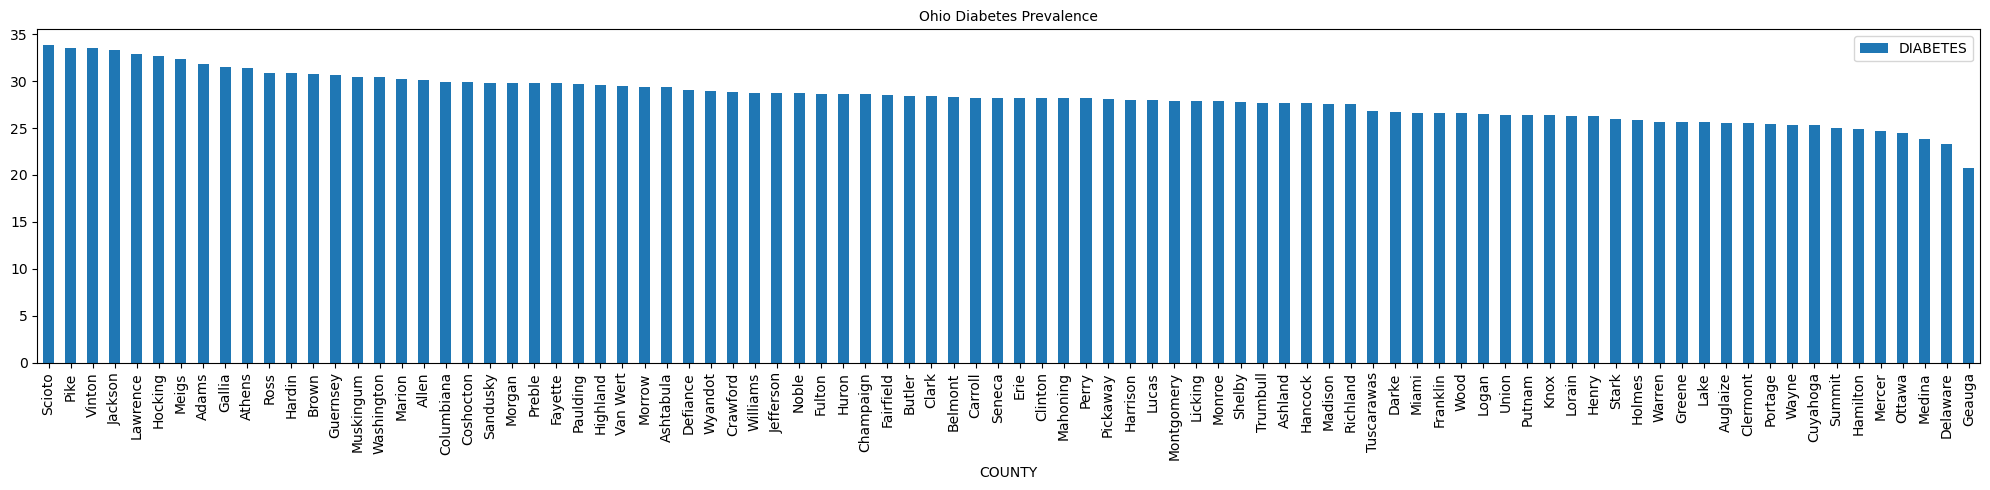

In [3]:
dfDisplay = dfCMSChronicPrevalence[(dfCMSChronicPrevalence.STATE == 'Ohio') & (dfCMSChronicPrevalence.YEAR == 2018)]
dfDisplay= dfDisplay.sort_values('DIABETES',ascending=False)
dfDisplay.plot(x="COUNTY", y="DIABETES", kind="bar", figsize=(20,5))
plt.title("Ohio Diabetes Prevalence", fontsize=10)
plt.tight_layout()
plt.show()

## AHRQ Data
Call AHRQ SDOH Data notebook using year parameter.

In [4]:
parm_AHRQCountySDOH_years = ['2015', '2016', '2017', '2018']
# currently not including NOAAC - temperature by month
parm_AHRQCountySDOH_surveys = ["ACS", "AHA", "AMFAR", "CCBP", "CDCSVI", "CEN", "CRDC", "EPAA", "FARA", "FEA", "HHC", "HIFLD", "HRSA", "MHSVI", "MP", "NCHS", "NEPHTN", "NHC", "NOAAS", "POS", "SAHIE", "SAIPE", "SEDA"]
parm_AHRQCountySDOH_questions = ["CDCW_INJURY_DTH_RATE", "CDCW_TRANSPORT_DTH_RATE", "CDCW_SELFHARM_DTH_RATE", "CDCW_ASSAULT_DTH_RATE", "CHR_TOT_MENTAL_PROV", "CHR_MENTAL_PROV_RATE", "CHR_SEGREG_BLACK", "CHR_PCT_ALCOHOL_DRIV_DEATH", "CHR_PCT_EXCESS_DRINK", "CHR_PCT_FOOD", "CHR_SEGREG_BLACK", "CHR_SEGREG_NON_WHITE"]
%run ../../etl/dataAHRQCountySDOH.ipynb
dfAHRQCountySDOH = out_AHRQCountySDOH()

## Explore AHRQ Data
Show correlations for food related SDOH.

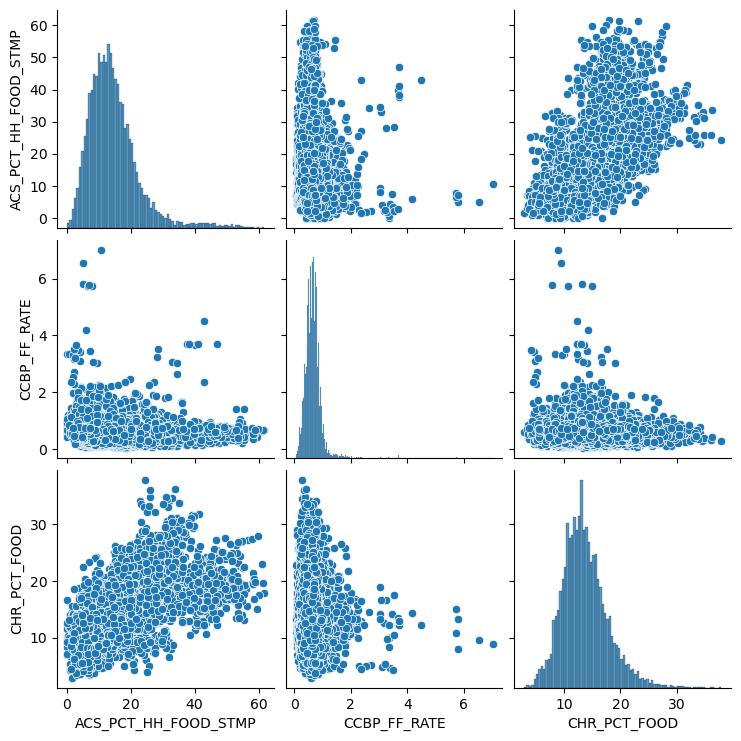

In [5]:
dfAHRQFood = dfAHRQCountySDOH[['STATE', 'COUNTY', 'ACS_PCT_HH_FOOD_STMP', 'CCBP_FF_RATE', 'CHR_PCT_FOOD']]
sns.pairplot(dfAHRQFood)

## Merge Data and Create Training, Test sets

In [7]:
dfMerged = pd.merge(dfAHRQCountySDOH, dfCMSChronicPrevalence, how='inner', left_on=['STATE','COUNTY', 'YEAR'], right_on = ['STATE','COUNTY', 'YEAR'])
dfMerged = dfMerged[dfMerged['YEAR'] < 2018]

X = dfMerged.drop(["DIABETES", "STATE", "COUNTY", "FIPS", "YEAR"], axis = 1)
Y = dfMerged["DIABETES"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y ,test_size = 0.2, random_state = 42)
pd.set_option('display.max_rows', 20)

# Feature Selection

## Random Forest Regressor feature selection

R2 Score:  0.9772693460746851


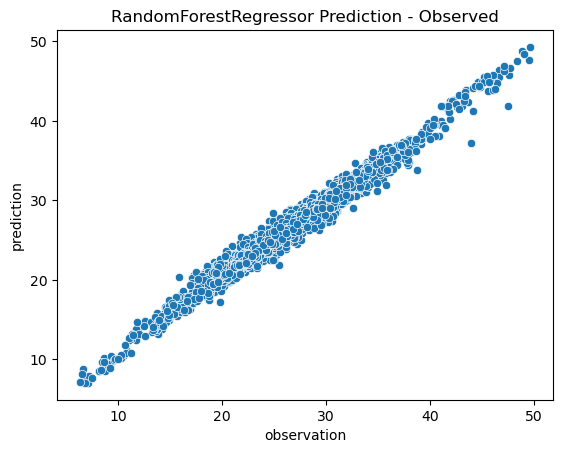

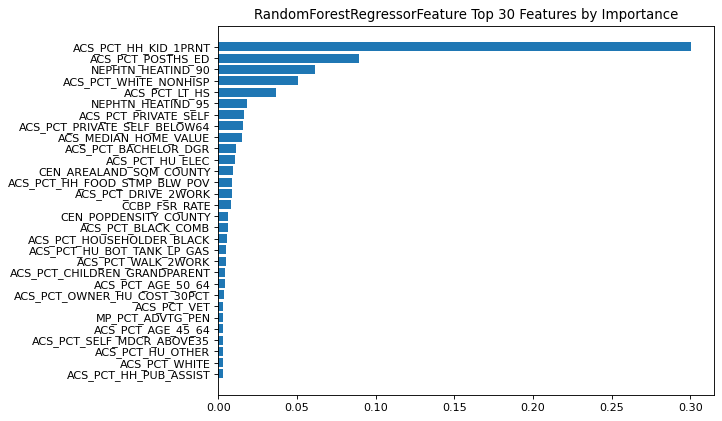

R2 Score:  0.9772693460746851


In [9]:
parm_features_RandomForestReg_X = X_train # features dataframe
parm_features_RandomForestReg_Y = Y_train # target dataframe

%run ../../features/features_RandomForestReg.ipynb
listSelectedFeatures = out_features_RandomForestReg_X()
print("R2 Score: ", out_features_RandomForestReg_X_R2())

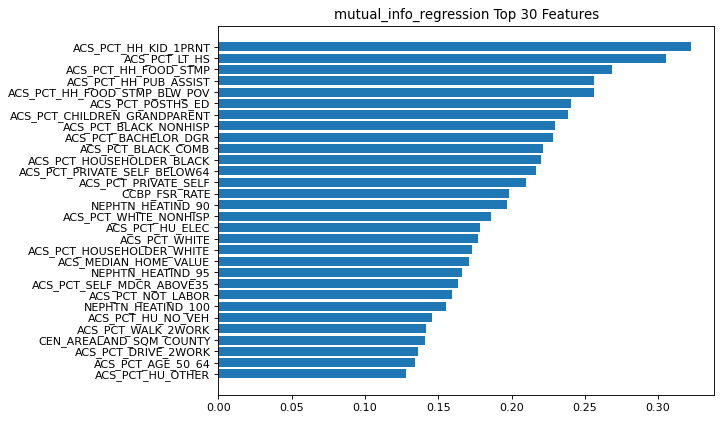

In [18]:
#parm_features_MutualInformationReg_X = X_train # features dataframe
#parm_features_MutualInformationReg_Y = Y_train # target dataframe
#%run features_MutualInformationReg.ipynb
#listSelectedFeatures = out_features_MutualInformationReg_X()[0:30]

In [11]:
X_train_selected = X_train[listSelectedFeatures]
X_test_selected = X_test[listSelectedFeatures]

# Develop Models and Evaluate Performance

## Linear Regression
Use selected features

In [12]:
# define the model
lr = LinearRegression()
lr.fit(X_train_selected, Y_train)

# Coefficient of Determination
lr.score(X_test_selected,Y_test)

0.7108983908860887

## Random Forest
Use all features

In [15]:
# define the model
rf = RandomForestRegressor(n_estimators= 20, random_state=5)
# fit the random forest model
rf.fit(X_train, Y_train)

# Coefficient of Determination
#rf.score(X_test,Y_test)

RandomForestRegressor(n_estimators=20, random_state=5)

R2 Score:  0.8401773525966435


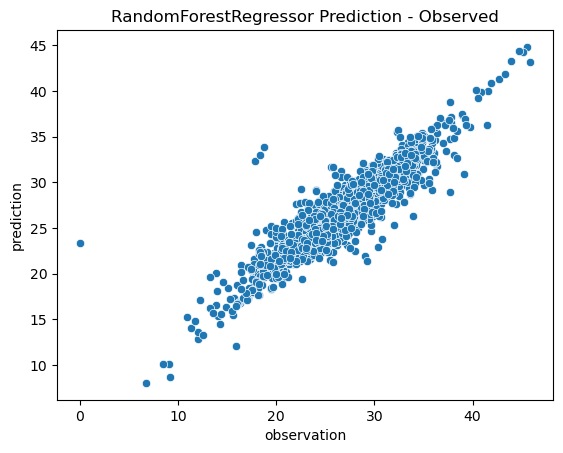

In [16]:
Y_pred = rf.predict(X_test)
print("R2 Score: ", r2_score(Y_test,Y_pred))

list = Y_test.tolist()
scatterplot(x=list, y=Y_pred)
plt.title('RandomForestRegressor Prediction - Observed')
plt.xlabel("observation")
plt.ylabel("prediction")
plt.show()

## Boosted Trees
Use all features

In [17]:
from sklearn.ensemble import GradientBoostingRegressor
xgb = GradientBoostingRegressor(n_estimators=100, learning_rate=1.0, max_depth=2, random_state=0).fit(X_train, Y_train)
#xgb.score(X_test, Y_test)

R2 Score:  0.7376793932119982


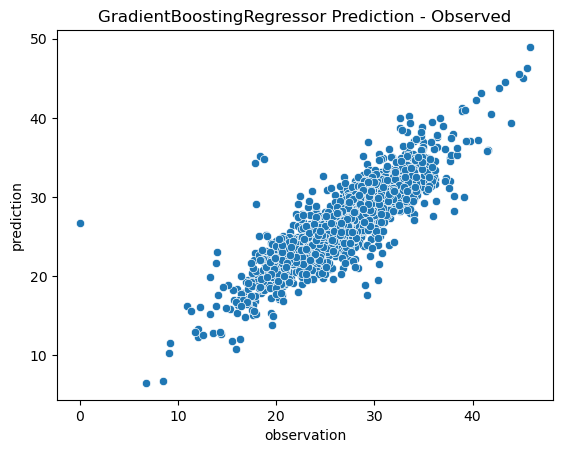

In [18]:
Y_pred = xgb.predict(X_test)
print("R2 Score: ", r2_score(Y_test,Y_pred))

list = Y_test.tolist()
scatterplot(x=list, y=Y_pred)
plt.title('GradientBoostingRegressor Prediction - Observed')
plt.xlabel("observation")
plt.ylabel("prediction")
plt.show()

# Evaluate performance future year

### Create test sets for future year

In [20]:
dfMergedFuture = pd.merge(dfAHRQCountySDOH, dfCMSChronicPrevalence, how='inner', left_on=['STATE','COUNTY', 'YEAR'], right_on = ['STATE','COUNTY', 'YEAR'])
dfMergedFuture = dfMergedFuture[dfMergedFuture['YEAR'] == 2018]

X_testFuture = dfMergedFuture.drop(["DIABETES", "STATE", "COUNTY", "FIPS", "YEAR"], axis = 1)
X_testFutureSelected = X_testFuture[listSelectedFeatures]

Y_testFuture = dfMergedFuture["DIABETES"]

## Regression

In [21]:
lr.fit(X_testFutureSelected, Y_testFuture)

# Coefficient of Determination
lr.score(X_testFutureSelected, Y_testFuture)

0.7341214288199085

## Random Forest

In [23]:
# fit the random forest model
rf.fit(X_testFuture, Y_testFuture)

RandomForestRegressor(n_estimators=20, random_state=5)

R2 Score:  0.9597850242375107


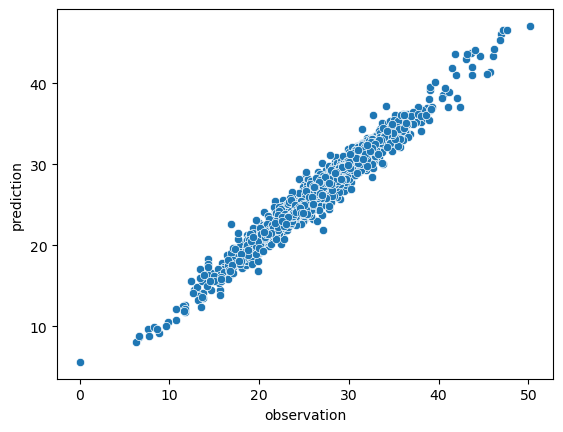

In [25]:
Y_pred = rf.predict(X_testFuture)
print("R2 Score: ", r2_score(Y_testFuture,Y_pred))

list = Y_testFuture.tolist()
scatterplot(x=list, y=Y_pred)
plt.xlabel("observation")
plt.ylabel("prediction")
plt.show()

## Boosted Trees

R2 Score:  0.7754475060655979


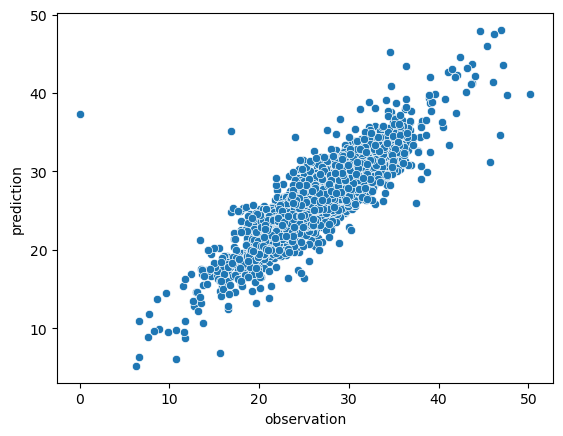

In [22]:
Y_pred = xgb.predict(X_test)
print("R2 Score: ", r2_score(Y_test,Y_pred))

list = Y_test.tolist()
scatterplot(x=list, y=Y_pred)
plt.xlabel("observation")
plt.ylabel("prediction")
plt.show()

# Publish Models